In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline

from torch.optim.lr_scheduler import StepLR

from model import NN
from functions import uniform_circle_loss_function_method2, gaussian_loss_function
from train import training_routine
from train import testing_routine
from visuals import plot_transformed_grid_and_density, compute_uniform_circle_density, plot_transformed_circle_grid_and_density

from pathlib import Path

In [2]:
torch.set_default_dtype(torch.float64)
torch.manual_seed(2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

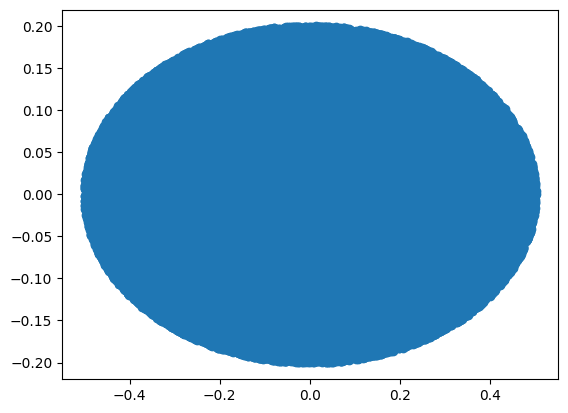

In [4]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2), device='cpu'):
    data = (torch.rand((max_num,2), device=device)-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale, device=device)
    return data

training_set = generate_ellipse(max_num=100000, scale=(0.5,0.2), device=device)
validation_set = generate_ellipse(max_num=10000, scale=(0.5,0.2), device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [5]:
torch.manual_seed(0)

model = NN(num_coupling_layers=30,layer_size=2, split_size_x1=1, nn_size=(1,10)).to(device)
model

NN(
  (layers): ModuleList(
    (0-29): 30 x CouplingLayer(
      (t_net): ModuleList(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
      (s_net): ModuleList(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): Linear(in_features=10, out_features=10, bias=True)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
      (activation): ReLU()
    )
  )
)

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)
num_epoch = 20

In [7]:
%%time

for epoch in range(num_epoch):
    print(epoch)
    training_routine(model, train_loader, optimizer, uniform_circle_loss_function_method2) 
    print(testing_routine(model, validation_loader, uniform_circle_loss_function_method2))
    scheduler.step()

0


77it [00:12,  6.12it/s]
62it [00:02, 30.99it/s]


tensor(-5255.2773, device='cuda:0')
1


77it [00:09,  8.22it/s]
62it [00:01, 31.25it/s]


tensor(-11161.3217, device='cuda:0')
2


77it [00:09,  7.81it/s]
62it [00:01, 31.23it/s]


tensor(-16369.6824, device='cuda:0')
3


77it [00:10,  7.62it/s]
62it [00:02, 30.72it/s]


tensor(-18478.5985, device='cuda:0')
4


77it [00:09,  8.31it/s]
62it [00:01, 31.52it/s]


tensor(-18558.3664, device='cuda:0')
5


77it [00:09,  8.04it/s]
62it [00:02, 30.53it/s]


tensor(-18610.1408, device='cuda:0')
6


77it [00:09,  7.88it/s]
62it [00:02, 25.89it/s]


tensor(-18640.5853, device='cuda:0')
7


77it [00:12,  6.16it/s]
62it [00:03, 19.89it/s]


tensor(-18651.6026, device='cuda:0')
8


77it [00:11,  6.53it/s]
62it [00:01, 33.39it/s]


tensor(-18659.0640, device='cuda:0')
9


77it [00:09,  8.33it/s]
62it [00:02, 30.47it/s]


tensor(-18646.5366, device='cuda:0')
10


77it [00:09,  8.17it/s]
62it [00:01, 31.49it/s]


tensor(-18667.6158, device='cuda:0')
11


77it [00:09,  8.26it/s]
62it [00:02, 28.45it/s]


tensor(-18663.9108, device='cuda:0')
12


77it [00:10,  7.50it/s]
62it [00:02, 22.06it/s]


tensor(-18659.0474, device='cuda:0')
13


77it [00:12,  6.14it/s]
62it [00:02, 20.97it/s]


tensor(-18673.5329, device='cuda:0')
14


77it [00:12,  6.15it/s]
62it [00:03, 19.67it/s]


tensor(-18666.9920, device='cuda:0')
15


77it [00:12,  6.03it/s]
62it [00:03, 20.23it/s]


tensor(-18680.2916, device='cuda:0')
16


77it [00:12,  5.98it/s]
62it [00:03, 19.95it/s]


tensor(-18672.8481, device='cuda:0')
17


77it [00:12,  6.39it/s]
62it [00:01, 31.12it/s]


tensor(-18663.3762, device='cuda:0')
18


77it [00:09,  8.28it/s]
62it [00:01, 32.33it/s]


tensor(-18673.7125, device='cuda:0')
19


77it [00:09,  7.92it/s]
62it [00:02, 27.97it/s]

tensor(-18680.8898, device='cuda:0')
CPU times: total: 5min 4s
Wall time: 4min 21s


C:\Users\Admin\AppData\Local\Temp\ipykernel_23672\4094961112.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

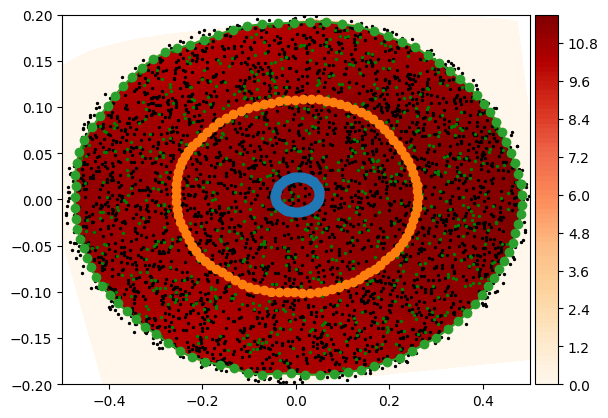

In [10]:
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

from model import register_activation_hooks, remove_activation_hooks
import numpy as np
from matplotlib import pyplot as plt

def plot_transformed_circle_grid_and_density(model, train_loader, device, sampling_data, grid_shape,
                                             x_lim=(-1, 1), y_lim=(-1, 1),
                                             density_function=compute_uniform_circle_density):
    fig, ax = plt.subplots()

    plt.xlim(*x_lim)
    plt.ylim(*y_lim)



    x = np.linspace(-1,1, 300)
    y = np.linspace(-1,1, 300)

    xv, yv = np.meshgrid(x, y, indexing='xy')
    horizontal_lines = np.stack((xv, yv), axis=2)

    xv, yv = np.meshgrid(x, y, indexing='ij')
    vertical_lines = np.stack((xv, yv), axis=2)  # vertical_lines

    all_grid_points = np.concatenate(np.concatenate((horizontal_lines, vertical_lines)), axis=0)
    all_grid_points = torch.tensor(all_grid_points, device=device)
    
    t = model(all_grid_points, reverse=True).detach()
    t = t.to('cpu')
    t = t.numpy()
    temp_t = t[:t.shape[0] // 2]
    x = np.array(temp_t)[:, 0]
    y = np.array(temp_t)[:, 1]
    z = density_function(model, torch.tensor(temp_t, device=device), device)

    cntr2 = ax.tricontourf(x, y, z, levels=100, cmap="OrRd")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cntr2, cax=cax)


    angles = np.linspace(0, 2 * np.pi, grid_shape[0])
    circles = [np.stack((np.cos(angles), np.sin(angles)), axis=1) * s for s in np.linspace(0.1, 1, grid_shape[1])]
    all_grid_points = np.concatenate(circles)
    all_grid_points = torch.tensor(all_grid_points, device=device)

    t = model(all_grid_points, reverse=True).detach()
    t = t.to('cpu')
    t = t.numpy()
    temp_t = t
    x = np.array(temp_t)[:, 0]
    y = np.array(temp_t)[:, 1]
    z = density_function(model, torch.tensor(temp_t, device=device), device)

    circles_transformed = np.split(np.array(t), grid_shape[1])
    for circle in circles_transformed:
        ax.plot(circle[:, 0], circle[:, 1], '-o')

    ax.scatter(train_loader[:, 0][:3200], train_loader[:, 1][:3200], c='black', alpha=1, s=2)
    output = model(torch.tensor(sampling_data, device=device), reverse=True)
    output = output.to('cpu').detach().numpy()
    ax.scatter(np.array(output)[:, 0], np.array(output)[:, 1], c='green', alpha=1, s=2)

    return 0

sampling_data = generate_ellipse(1000, (1, 1))

plot_transformed_circle_grid_and_density(model, training_set.to('cpu'), device, sampling_data, grid_shape=(100,3),
                                             x_lim=(-0.5, 0.5), y_lim=(-0.2, 0.2),
                                             density_function=compute_uniform_circle_density)

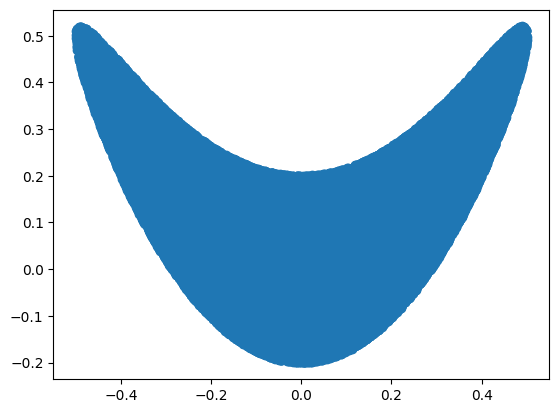

In [11]:
def generate_banana(n=100000, device=device):
    train_loader = generate_ellipse(n, device=device)
    train_loader[:, 1] = train_loader[:,1] + 2*train_loader[:,0]**2
    return train_loader
training_set = generate_banana(n=100000, device=device)
validation_set = generate_banana(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [19]:
model_banana = NN(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200)).to(device)

In [20]:
optimizer = torch.optim.SGD(model_banana.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)
num_epoch = 20

In [14]:
%%time

for epoch in range(num_epoch):
    print(epoch)
    training_routine(model_banana, train_loader, optimizer, uniform_circle_loss_function_method2) 
    print(testing_routine(model_banana, validation_loader, uniform_circle_loss_function_method2))
    scheduler.step()

0


77it [00:06, 12.05it/s]
62it [00:00, 83.90it/s]


tensor(-8943.1204, device='cuda:0')
1


77it [00:04, 16.47it/s]
62it [00:00, 93.66it/s]


tensor(-14202.0058, device='cuda:0')
2


77it [00:04, 17.37it/s]
62it [00:00, 93.80it/s]


tensor(-17054.3268, device='cuda:0')
3


77it [00:04, 16.61it/s]
62it [00:00, 92.81it/s]


tensor(-18034.5009, device='cuda:0')
4


77it [00:04, 17.38it/s]
62it [00:00, 93.22it/s]


tensor(-18219.6919, device='cuda:0')
5


77it [00:05, 14.88it/s]
62it [00:00, 66.67it/s]


tensor(-18318.1097, device='cuda:0')
6


77it [00:05, 14.26it/s]
62it [00:00, 66.10it/s]


tensor(-18347.0695, device='cuda:0')
7


77it [00:05, 13.94it/s]
62it [00:00, 67.39it/s]


tensor(-18406.2581, device='cuda:0')
8


77it [00:05, 14.00it/s]
62it [00:00, 65.06it/s]


tensor(-18430.0949, device='cuda:0')
9


77it [00:05, 14.15it/s]
62it [00:00, 68.21it/s]


tensor(-18445.3835, device='cuda:0')
10


77it [00:05, 14.18it/s]
62it [00:00, 91.85it/s]


tensor(-18445.7439, device='cuda:0')
11


77it [00:04, 16.82it/s]
62it [00:00, 93.51it/s]


tensor(-18465.0087, device='cuda:0')
12


77it [00:04, 17.25it/s]
62it [00:00, 93.80it/s]


tensor(-18446.4508, device='cuda:0')
13


77it [00:04, 17.04it/s]
62it [00:00, 92.81it/s]


tensor(-18479.8801, device='cuda:0')
14


77it [00:04, 16.91it/s]
62it [00:00, 95.53it/s]


tensor(-18451.7253, device='cuda:0')
15


77it [00:04, 17.68it/s]
62it [00:00, 92.26it/s]


tensor(-18457.4125, device='cuda:0')
16


77it [00:04, 17.11it/s]
62it [00:00, 96.27it/s]


tensor(-18447.9681, device='cuda:0')
17


77it [00:04, 17.50it/s]
62it [00:00, 94.80it/s]


tensor(-18489.6879, device='cuda:0')
18


77it [00:04, 17.34it/s]
62it [00:00, 93.66it/s]


tensor(-18458.4364, device='cuda:0')
19


77it [00:04, 17.16it/s]
62it [00:00, 93.80it/s]

tensor(-18488.3938, device='cuda:0')
CPU times: total: 2min 37s
Wall time: 1min 52s


C:\Users\Admin\AppData\Local\Temp\ipykernel_23672\4094961112.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

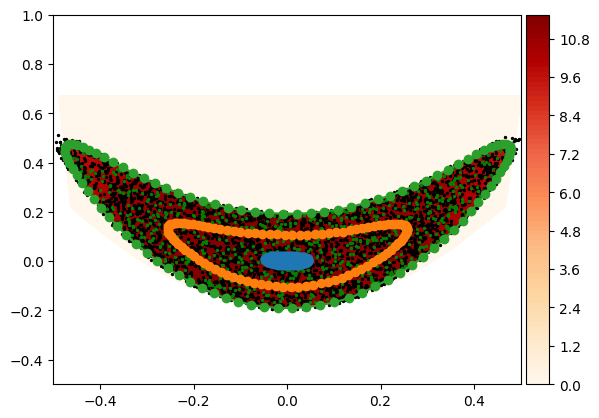

In [18]:
plot_transformed_circle_grid_and_density(model_banana, training_set.to('cpu'), device, sampling_data, grid_shape=(100,3),
                                             x_lim=(-0.5, 0.5), y_lim=(-0.5, 1.),
                                             density_function=compute_uniform_circle_density)

In [21]:
%%time

for epoch in range(num_epoch):
    print(epoch)
    training_routine(model_banana, train_loader, optimizer, uniform_circle_loss_function_method2) 
    print(testing_routine(model_banana, validation_loader, uniform_circle_loss_function_method2))
    scheduler.step()

0


77it [00:04, 16.20it/s]
62it [00:00, 93.80it/s]


tensor(-14071.7617, device='cuda:0')
1


77it [00:04, 17.30it/s]
62it [00:00, 92.59it/s]


tensor(-15347.6534, device='cuda:0')
2


77it [00:04, 16.53it/s]
62it [00:00, 94.37it/s]


tensor(-15913.6161, device='cuda:0')
3


77it [00:04, 17.43it/s]
62it [00:00, 92.12it/s]


tensor(-16361.7932, device='cuda:0')
4


77it [00:04, 17.22it/s]
62it [00:00, 90.77it/s]


tensor(-16786.5461, device='cuda:0')
5


77it [00:04, 17.01it/s]
62it [00:00, 91.98it/s]


tensor(-17215.8313, device='cuda:0')
6


77it [00:04, 17.02it/s]
62it [00:00, 90.78it/s]


tensor(-17664.1689, device='cuda:0')
7


77it [00:04, 17.43it/s]
62it [00:00, 93.37it/s]


tensor(-17976.2111, device='cuda:0')
8


77it [00:04, 17.60it/s]
62it [00:00, 94.95it/s]


tensor(-18057.0983, device='cuda:0')
9


77it [00:04, 17.37it/s]
62it [00:00, 95.83it/s]


tensor(-18091.2965, device='cuda:0')
10


77it [00:04, 17.22it/s]
62it [00:00, 94.80it/s]


tensor(-18147.7172, device='cuda:0')
11


77it [00:04, 17.50it/s]
62it [00:00, 95.09it/s]


tensor(-18178.7296, device='cuda:0')
12


77it [00:04, 17.50it/s]
62it [00:00, 95.23it/s]


tensor(-18200.6697, device='cuda:0')
13


77it [00:04, 17.52it/s]
62it [00:00, 95.82it/s]


tensor(-18231.8278, device='cuda:0')
14


77it [00:04, 17.00it/s]
62it [00:00, 94.36it/s]


tensor(-18258.7906, device='cuda:0')
15


77it [00:04, 17.33it/s]
62it [00:00, 95.97it/s]


tensor(-18279.3872, device='cuda:0')
16


77it [00:04, 17.49it/s]
62it [00:00, 95.53it/s]


tensor(-18286.6944, device='cuda:0')
17


77it [00:04, 17.49it/s]
62it [00:00, 95.38it/s]


tensor(-18304.3147, device='cuda:0')
18


77it [00:04, 16.92it/s]
62it [00:00, 92.95it/s]


tensor(-18308.1477, device='cuda:0')
19


77it [00:04, 17.06it/s]
62it [00:00, 93.66it/s]

tensor(-18340.7898, device='cuda:0')
CPU times: total: 2min 33s
Wall time: 1min 42s


C:\Users\Admin\AppData\Local\Temp\ipykernel_23672\4094961112.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

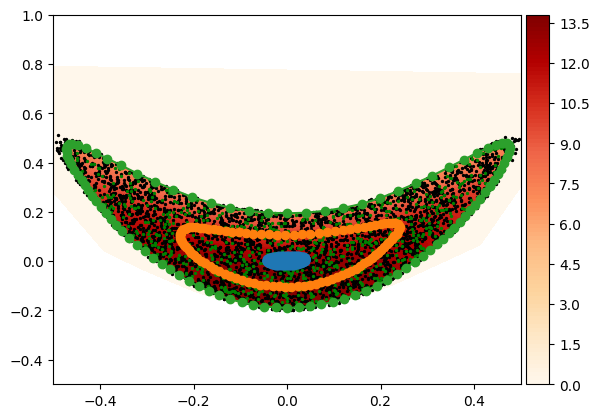

In [22]:
plot_transformed_circle_grid_and_density(model_banana, training_set.to('cpu'), device, sampling_data, grid_shape=(100,3),
                                             x_lim=(-0.5, 0.5), y_lim=(-0.5, 1.),
                                             density_function=compute_uniform_circle_density)

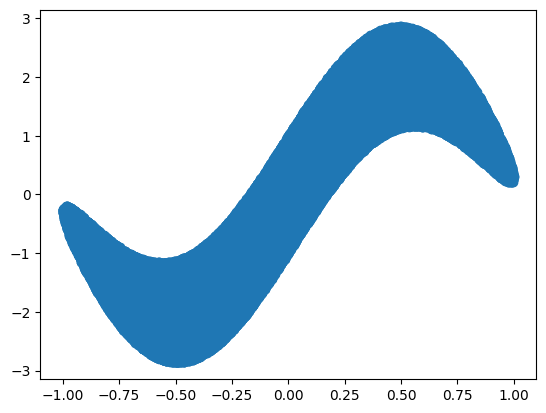

In [23]:
def generate_wave(n=100000, device='cpu'):
    train_loader = generate_ellipse(n, (1,1), device)
    train_loader[:, 1] = train_loader[:,1] + 2*torch.sin(3*train_loader[:,0])
    return train_loader
training_set = generate_wave(n=100000, device=device)
validation_set = generate_wave(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [34]:
model_wave = NN(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200)).to(device)

In [35]:
optimizer = torch.optim.SGD(model_wave.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epoch = 20

In [41]:
%%time

for epoch in range(num_epoch):
    print(epoch)
    training_routine(model_wave, train_loader, optimizer, uniform_circle_loss_function_method2) 
    print(testing_routine(model_wave, validation_loader, uniform_circle_loss_function_method2))
    scheduler.step()

0


77it [00:04, 16.16it/s]
62it [00:00, 91.99it/s]


tensor(1827.5199, device='cuda:0')
1


77it [00:04, 16.28it/s]
62it [00:00, 93.58it/s]


tensor(1819.6338, device='cuda:0')
2


77it [00:04, 16.99it/s]
62it [00:00, 91.85it/s]


tensor(1802.7256, device='cuda:0')
3


77it [00:04, 16.26it/s]
62it [00:00, 90.77it/s]


tensor(1791.2300, device='cuda:0')
4


77it [00:05, 13.36it/s]
62it [00:00, 63.01it/s]


tensor(1782.8178, device='cuda:0')
5


77it [00:05, 13.18it/s]
62it [00:01, 57.62it/s]


tensor(1776.0129, device='cuda:0')
6


77it [00:05, 13.44it/s]
62it [00:01, 59.44it/s]


tensor(1766.4552, device='cuda:0')
7


77it [00:05, 13.55it/s]
62it [00:00, 62.34it/s]


tensor(1763.0560, device='cuda:0')
8


77it [00:05, 13.49it/s]
62it [00:01, 58.38it/s]


tensor(1761.1649, device='cuda:0')
9


77it [00:05, 13.21it/s]
62it [00:01, 56.57it/s]


tensor(1747.9404, device='cuda:0')
10


77it [00:05, 12.96it/s]
62it [00:00, 64.99it/s]


tensor(1742.9987, device='cuda:0')
11


77it [00:05, 13.11it/s]
62it [00:01, 57.94it/s]


tensor(1736.1642, device='cuda:0')
12


77it [00:05, 13.28it/s]
62it [00:01, 58.05it/s]


tensor(1730.3416, device='cuda:0')
13


77it [00:06, 12.44it/s]
62it [00:01, 59.41it/s]


tensor(1721.0366, device='cuda:0')
14


77it [00:05, 13.26it/s]
62it [00:01, 58.60it/s]


tensor(1718.6968, device='cuda:0')
15


77it [00:05, 13.38it/s]
62it [00:01, 48.67it/s]


tensor(1713.0918, device='cuda:0')
16


77it [00:06, 12.48it/s]
62it [00:00, 67.91it/s]


tensor(1709.8626, device='cuda:0')
17


77it [00:05, 13.24it/s]
62it [00:01, 58.21it/s]


tensor(1714.6504, device='cuda:0')
18


77it [00:07, 10.71it/s]
62it [00:01, 39.34it/s]


tensor(1707.3050, device='cuda:0')
19


77it [00:06, 12.07it/s]
62it [00:01, 54.05it/s]

tensor(1699.6950, device='cuda:0')
CPU times: total: 2min 52s
Wall time: 2min 14s


C:\Users\Admin\AppData\Local\Temp\ipykernel_23672\4094961112.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

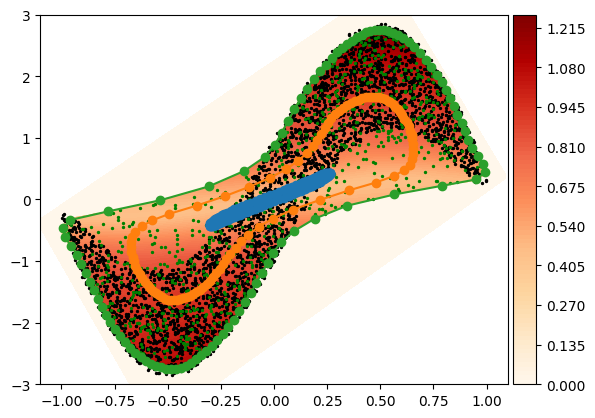

In [42]:
plot_transformed_circle_grid_and_density(model_wave, training_set.to('cpu'), device, sampling_data, grid_shape=(100,3),
                                             x_lim=(-1.1, 1.1), y_lim=(-3, 3.),
                                             density_function=compute_uniform_circle_density)

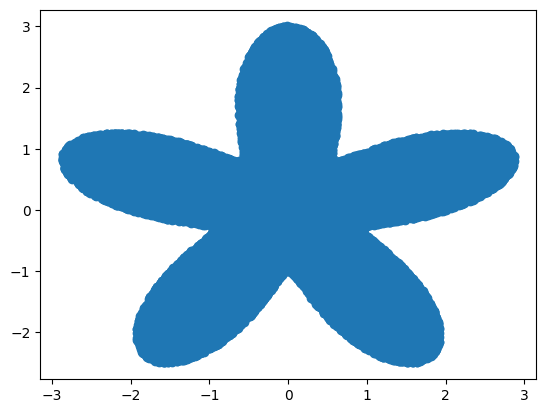

In [43]:
def generate_star(max_num = 10000, n_edges = 5, device='cpu'):
    data = generate_ellipse(max_num, scale=(3,3), device=device)
    angles = torch.arctan2(data[:,1],data[:,0])
    max_amplitude = torch.sin(n_edges*angles)+2
    amplitude = torch.sum(data**2,axis=1)**0.5
    data = data[amplitude <= max_amplitude]
    return data

training_set = generate_star(max_num=100000, n_edges=5, device=device)
validation_set = generate_star(max_num=10000, n_edges=5, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [44]:
model_star = NN(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200)).to(device)

In [52]:
optimizer = torch.optim.SGD(model_star.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epoch = 20

In [51]:
scheduler.get_last_lr()

[0.012851215656510309]

In [53]:
%%time

for epoch in range(num_epoch):
    print(epoch)
    training_routine(model_star, train_loader, optimizer, uniform_circle_loss_function_method2) 
    print(testing_routine(model_star, validation_loader, uniform_circle_loss_function_method2))
    scheduler.step()

0


39it [00:03, 12.91it/s]
31it [00:00, 60.08it/s]


tensor(6484.9564, device='cuda:0')
1


39it [00:03, 12.98it/s]
31it [00:00, 55.80it/s]


tensor(6484.4846, device='cuda:0')
2


39it [00:02, 13.37it/s]
31it [00:00, 69.51it/s]


tensor(6484.1509, device='cuda:0')
3


39it [00:02, 13.71it/s]
31it [00:00, 68.43it/s]


tensor(6483.9200, device='cuda:0')
4


39it [00:02, 15.95it/s]
31it [00:00, 85.39it/s]


tensor(6483.6428, device='cuda:0')
5


39it [00:02, 15.69it/s]
31it [00:00, 71.31it/s]


tensor(6483.3807, device='cuda:0')
6


39it [00:02, 15.95it/s]
31it [00:00, 88.06it/s]


tensor(6483.2337, device='cuda:0')
7


39it [00:02, 15.92it/s]
31it [00:00, 94.51it/s]


tensor(6483.0587, device='cuda:0')
8


39it [00:02, 15.82it/s]
31it [00:00, 68.28it/s]


tensor(6482.9319, device='cuda:0')
9


39it [00:02, 14.36it/s]
31it [00:00, 88.67it/s]


tensor(6482.7355, device='cuda:0')
10


39it [00:02, 15.80it/s]
31it [00:00, 69.82it/s]


tensor(6482.6324, device='cuda:0')
11


39it [00:02, 16.10it/s]
31it [00:00, 91.18it/s]


tensor(6482.5537, device='cuda:0')
12


39it [00:02, 16.39it/s]
31it [00:00, 92.81it/s]


tensor(6482.4833, device='cuda:0')
13


39it [00:02, 16.06it/s]
31it [00:00, 89.60it/s]


tensor(6482.3536, device='cuda:0')
14


39it [00:02, 16.14it/s]
31it [00:00, 94.79it/s]


tensor(6482.2286, device='cuda:0')
15


39it [00:02, 15.64it/s]
31it [00:00, 68.89it/s]


tensor(6482.1338, device='cuda:0')
16


39it [00:02, 15.73it/s]
31it [00:00, 91.71it/s]


tensor(6482.0989, device='cuda:0')
17


39it [00:02, 16.33it/s]
31it [00:00, 83.78it/s]


tensor(6481.9692, device='cuda:0')
18


39it [00:02, 14.64it/s]
31it [00:00, 90.64it/s]


tensor(6481.8806, device='cuda:0')
19


39it [00:02, 15.49it/s]
31it [00:00, 89.58it/s]

tensor(6481.7894, device='cuda:0')
CPU times: total: 1min 44s
Wall time: 59.4 s


C:\Users\Admin\AppData\Local\Temp\ipykernel_23672\4094961112.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

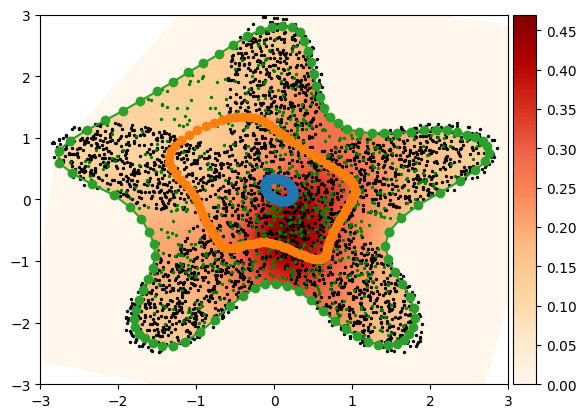

In [54]:
plot_transformed_circle_grid_and_density(model_star, training_set.to('cpu'), device, sampling_data, grid_shape=(100,3),
                                             x_lim=(-3, 3), y_lim=(-3, 3.),
                                             density_function=compute_uniform_circle_density)

In [59]:
model_star = NN(num_coupling_layers=16,layer_size=2, split_size_x1=1, nn_size=(1,200)).to(device)

In [60]:
optimizer = torch.optim.SGD(model_star.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epoch = 20

In [61]:
%%time

for epoch in range(num_epoch):
    print(epoch)
    training_routine(model_star, train_loader, optimizer, uniform_circle_loss_function_method2) 
    print(testing_routine(model_star, validation_loader, uniform_circle_loss_function_method2))
    scheduler.step()

0


39it [00:05,  6.79it/s]
31it [00:00, 31.89it/s]


tensor(19860.1956, device='cuda:0')
1


39it [00:05,  6.88it/s]
31it [00:00, 32.39it/s]


tensor(15084.6939, device='cuda:0')
2


39it [00:05,  6.63it/s]
31it [00:01, 26.43it/s]


tensor(12286.9290, device='cuda:0')
3


39it [00:05,  7.69it/s]
31it [00:00, 47.91it/s]


tensor(8946.2359, device='cuda:0')
4


39it [00:04,  8.36it/s]
31it [00:00, 31.86it/s]


tensor(7671.5226, device='cuda:0')
5


39it [00:05,  7.07it/s]
31it [00:00, 32.56it/s]


tensor(7490.9873, device='cuda:0')
6


39it [00:05,  6.58it/s]
31it [00:00, 33.19it/s]


tensor(7349.4082, device='cuda:0')
7


39it [00:05,  7.10it/s]
31it [00:01, 23.36it/s]


tensor(7244.2782, device='cuda:0')
8


39it [00:06,  5.60it/s]
31it [00:01, 23.43it/s]


tensor(7149.9173, device='cuda:0')
9


39it [00:07,  5.51it/s]
31it [00:01, 24.24it/s]


tensor(7073.1517, device='cuda:0')
10


39it [00:05,  6.70it/s]
31it [00:00, 34.03it/s]


tensor(7001.2444, device='cuda:0')
11


39it [00:05,  7.16it/s]
31it [00:01, 30.50it/s]


tensor(6936.1822, device='cuda:0')
12


39it [00:04,  7.97it/s]
31it [00:00, 48.51it/s]


tensor(6886.5057, device='cuda:0')
13


39it [00:04,  8.63it/s]
31it [00:00, 36.43it/s]


tensor(6846.5614, device='cuda:0')
14


39it [00:04,  8.62it/s]
31it [00:00, 47.18it/s]


tensor(6806.7176, device='cuda:0')
15


39it [00:04,  8.82it/s]
31it [00:00, 48.59it/s]


tensor(6774.3464, device='cuda:0')
16


39it [00:04,  8.88it/s]
31it [00:00, 48.59it/s]


tensor(6748.0537, device='cuda:0')
17


39it [00:04,  8.67it/s]
31it [00:00, 44.48it/s]


tensor(6719.9735, device='cuda:0')
18


39it [00:05,  7.02it/s]
31it [00:00, 31.89it/s]


tensor(6698.8798, device='cuda:0')
19


39it [00:05,  6.98it/s]
31it [00:00, 32.46it/s]

tensor(6679.6053, device='cuda:0')
CPU times: total: 2min 42s
Wall time: 2min 6s


C:\Users\Admin\AppData\Local\Temp\ipykernel_23672\4094961112.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

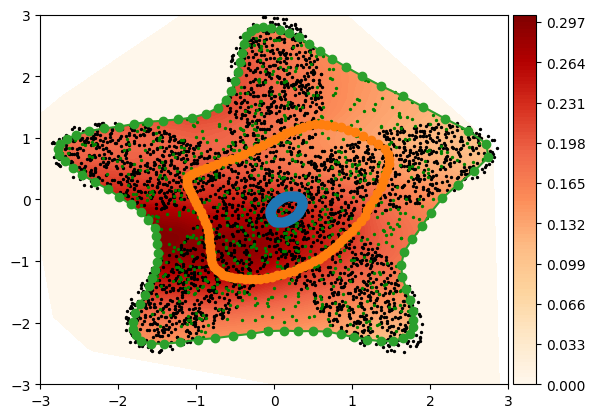

In [62]:
plot_transformed_circle_grid_and_density(model_star, training_set.to('cpu'), device, sampling_data, grid_shape=(100,3),
                                             x_lim=(-3, 3), y_lim=(-3, 3.),
                                             density_function=compute_uniform_circle_density)